In [1]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms,utils
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
def readImg(path,imgs):
    ims = {}
    for img in imgs:
        try:
            im = Image.open(path+"/"+img)
            ims[img] = im
        except Exception as Error:
            print(img+"Error")
    return ims
def read_raw_dataset(root_path,classes):
    outputpath = root_path
    raw_img = {}
    for cls in classes:
        path = outputpath+"/"+cls
        imgs = np.sort( os.listdir(path) )
        imgs_jpg = np.char.find(imgs,".jpg")>0
        raw_img[cls] = readImg(path,imgs[imgs_jpg])
    return raw_img
def crop_and_resize(im,size):
    im_np = np.array( im )
    H = im_np.shape[0]
    W = im_np.shape[1]
    num_H = H//size
    num_W = W//size
    skip_H = (H-num_H*size)//2
    skip_W = (W-num_W*size)//2
    im_np_2 = im_np[skip_H:skip_H+num_H*size,skip_W:skip_W+num_W*size,:].reshape(num_H,size,num_W,size,im_np.shape[-1]).transpose((0,2,1,3,4)).reshape(-1,size,size,im_np.shape[-1])
    im_np_1 = im_np[0:num_H*size,0:num_W*size,:].reshape(num_H,size,num_W,size,im_np.shape[-1]).transpose((0,2,1,3,4)).reshape(-1,size,size,im_np.shape[-1])
    im_np = np.stack( (im_np_1,im_np_2)).reshape(-1,size,size,im_np.shape[-1])
    #print( im_np.shape )
    return im_np
def resize_img(im,ratio):
    H = im.size[0]
    W = im.size[1]
    return im.resize(( int(H*ratio),int(W*ratio)),resample = Image.LANCZOS )
def get_multi_scale_dataset(raw_img,scales,size):
    ratio = scales
    dataset = {}
    for cls in raw_img:
        dataset[cls] = {}
        for im in raw_img[cls]:
            dataset[cls][im] = {}
            for rt in ratio:
                resized_im = resize_img(raw_img[cls][im],rt)
                dataset[cls][im][rt] = crop_and_resize(resized_im,size)
    return dataset
# Given some scale [，], input: dataset, output: (xxx,224,224,3) with group [1,1,2,3,4,...]
def get_data_ready(dataset,scales):
    classes = list(dataset.keys())
    i = 0
    for scale in scales:
        for cls in classes:
            img_names = list(dataset[cls].keys())
            for img in img_names:
                if i == 0:
                    chunk = dataset[cls][img][scale]
                    group = np.repeat(int(img.split("_")[0]),chunk.shape[0])
                    label = np.repeat(cls,chunk.shape[0])
                else:
                    num_chunk = dataset[cls][img][scale].shape[0]
                    chunk = np.concatenate( (chunk,dataset[cls][img][scale]),axis = 0 )
                    group = np.concatenate( (group,np.repeat(int(img.split("_")[0]),num_chunk) ),axis = 0 )
                    label = np.concatenate( (label,np.repeat(cls,num_chunk) ),axis = 0 )
                i+=1

    return chunk,label,group
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [3]:
def ResNet_feat(X):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model_conv = nn.Sequential(*list(torchvision.models.resnet18(pretrained=True).children())[:-1]).double()
    for param in model_conv.parameters():
        param.requires_grad = False
    model_conv = model_conv.to(device)
    model_conv.eval()
    X_t = torch.from_numpy(X[:].transpose(0,3,1,2)).type(torch.DoubleTensor)
    
    num = X_t.shape[0]//100
    
    X_split = np.array_split(X_t,num)
    
    for i,xs in enumerate(X_split):
        print("Split "+str(i)+"/"+str(num))
        if i == 0:
            feat = np.squeeze(model_conv(xs).numpy())
        else:
            feat = np.concatenate( ( feat, np.squeeze(model_conv(xs).numpy()) ), axis=0 )
    return feat

Read the Data

In [4]:
# Scales: first resize to H*scale, W*scale
scales = [1,0.5,0.25,0.125]
# Take size*size chunks
size = 224
# Class
classes = ["0","1"]
# Data path
path = '/Users/scraed/Downloads/Raphael-jpg'
# Read the raw_img dictionary { class } {jpg names}
raw_img = read_raw_dataset(path,classes)   
# dataset structure:
# class: ["0","1"],filename: ["xxx.jpg"] scale: []
# Example: dataset["1"]['20_1.jpg'][0.5]  is a (280, 224, 224, 3) numpy array, 280 pieces of 224*224 picture chunks
dataset = get_multi_scale_dataset(raw_img,scales,size)

In [10]:
# Get all chunks from particular scale
# X:(xxx, 224,224,3), y:(xxx), group:(name of the picture)
X,y,group = get_data_ready(dataset,[0.25])
y = y.astype(int)

Calculate the variance

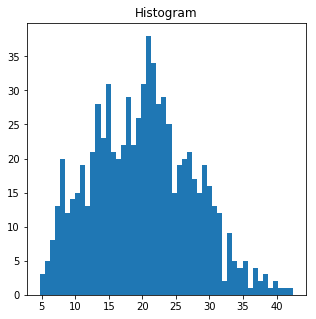

In [11]:
Xgray = X[:,:,:,0]*0.299 + X[:,:,:,1]*0.587 + X[:,:,:,2]*0.114
stds = np.std( Xgray, axis = (1,2) )
filt = stds>15
plt.rcParams['figure.figsize'] = (5,5)
plt.hist(stds, bins=50)  # arguments are passed to np.histogram
plt.title("Histogram")
plt.show()

Plot some figure

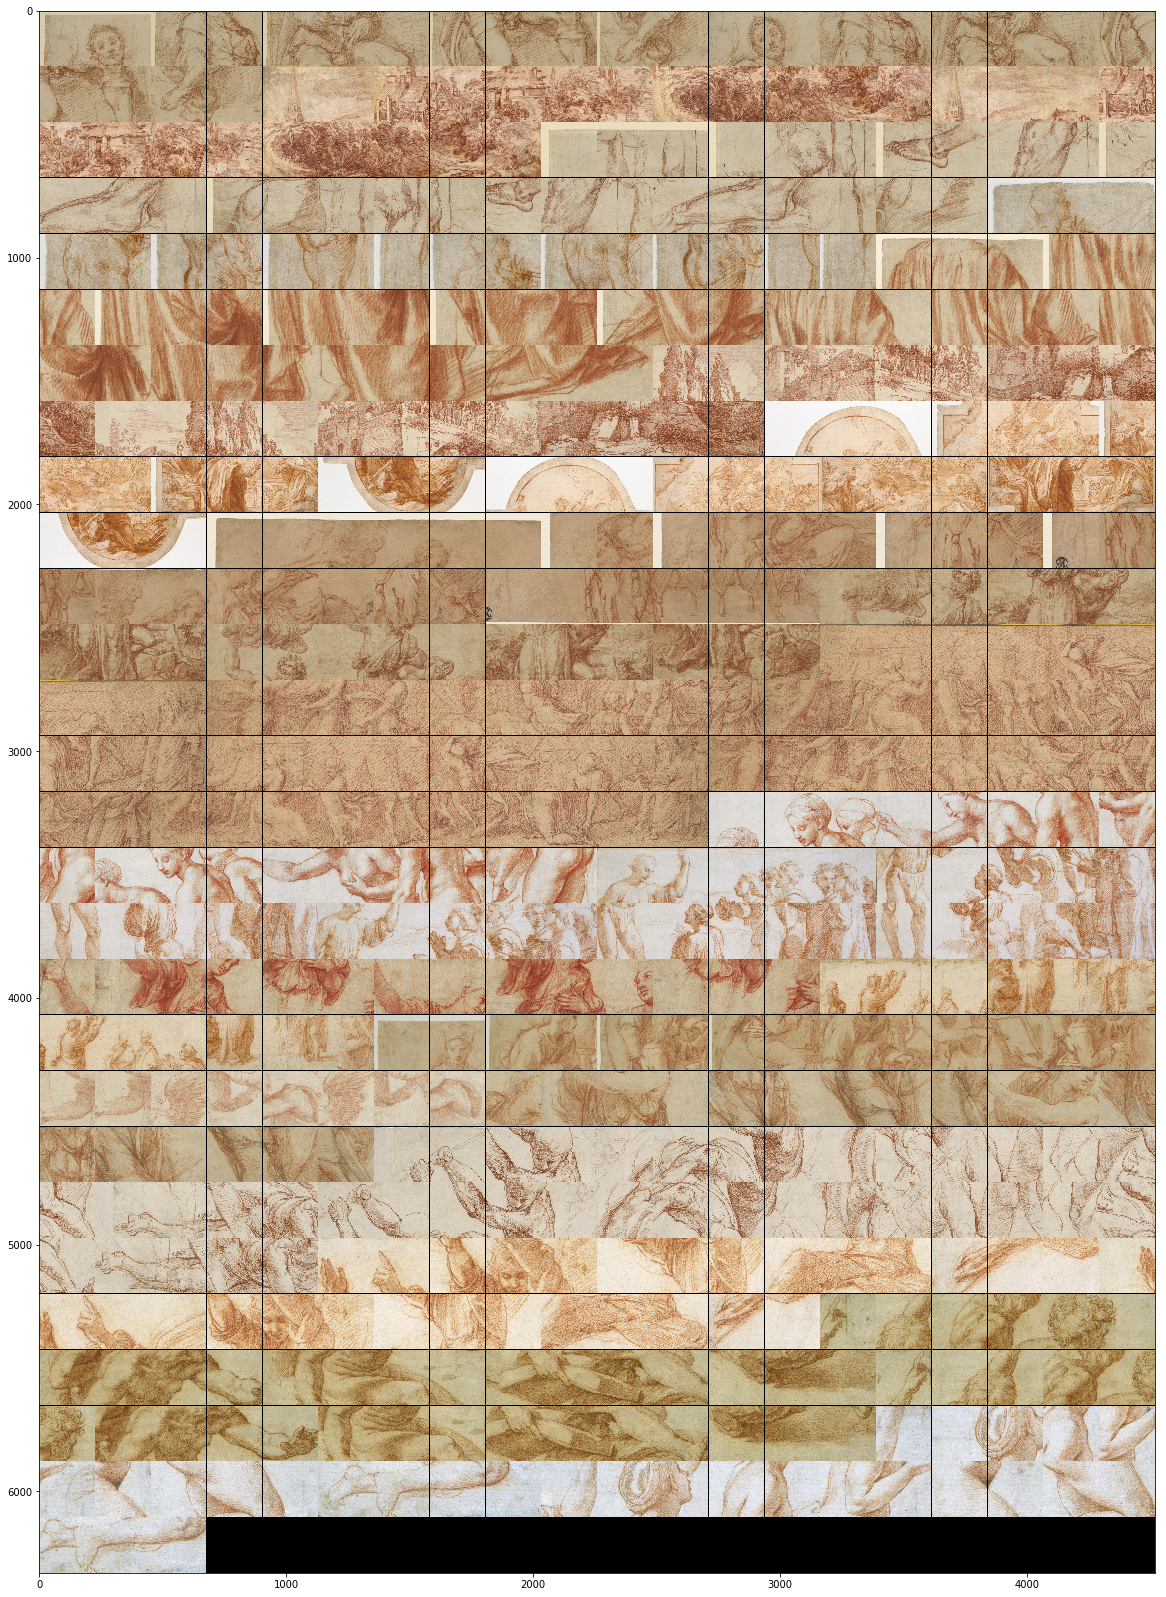

In [12]:
plt.rcParams['figure.figsize'] = (20,60)
out = torchvision.utils.make_grid( torch.from_numpy(X[filt].transpose(0,3,1,2)),nrow = 20 )
imshow(out)

In [13]:
X_feat_res = ResNet_feat(X)

Split 0/7
Split 1/7
Split 2/7
Split 3/7
Split 4/7
Split 5/7
Split 6/7


In [14]:
#scores = cross_val_score(SVC(), X_feat_res, y, cv=StratifiedKFold(n_splits=5), groups = group)
#clf = LinearSVC(C=1)
fold = 5
clf = RandomForestClassifier(max_depth=None, n_estimators=200)
scores = cross_val_score(clf, X_feat_res[filt], y[filt], cv=GroupKFold(n_splits=fold),groups = group[filt])
#scores = cross_val_score(clf, X_feat_res[filt], y[filt], cv=StratifiedKFold(n_splits=5))
print("Acc:"+str(np.average( scores )) )
print("Std:"+str( 2*np.std( scores )/np.sqrt(fold) ) )

Acc:0.542355997969
Std:0.0906802714074
